In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import logomaker

# Insert path to mavenn beginning of path
import os
import sys
abs_path_to_mavenn = os.path.abspath('../../../')
sys.path.insert(0, abs_path_to_mavenn)

# Load mavenn
import mavenn
print(mavenn.__path__)

['/Users/jkinney/github/mavenn/mavenn']


In [2]:
# Load example data
data_df = mavenn.load_example_dataset('sortseq')

# Separate test from data_df
ix_test = data_df['set']=='test'
test_df = data_df[ix_test].reset_index(drop=True)
print(f'test N: {len(test_df):,}')

# Remove test data from data_df
data_df = data_df[~ix_test].reset_index(drop=True)
print(f'training + validation N: {len(data_df):,}')
data_df.head(10)

test N: 9,329
training + validation N: 36,449


,set,ct_0,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,ct_8,ct_9,x
0,training,0,1,0,0,0,0,0,0,0,0,GGCTATACATTTTATGTTTCCGGGTCGTATTTTGTGTGG
1,training,0,0,0,0,0,0,0,0,1,0,GGCTTTACATTTTATGCTTCCTTCACGTATGTTGTGTCT
2,training,0,0,0,0,0,0,0,0,0,1,CGCTTTACACTTTCCGCTGCCGGCCCGTATTTTATGGGG
3,training,0,0,0,1,0,0,0,0,0,0,GGCTCTACCGTTTAGGCTTACGCCTCGAATATTGTGTGG
4,training,0,0,0,0,0,0,0,1,0,0,GGCTTTACACTTTACGCTTCCGTATCTTACGTTATGTGG
5,validation,0,0,0,0,0,0,2,0,0,0,GGATTTACACCATATGCCACCGGCTCATATGTTGTGCGG
6,validation,0,0,0,1,0,0,0,0,0,0,GGCTTTACACATCATGCTTCCGGCTCTTATGCCGTGATG
7,validation,2,0,0,0,0,0,0,0,0,0,GCCTTTAGAATTTATGTTTCCGTCACGTATGATGTGTAT
8,training,0,0,0,0,1,0,0,0,0,0,GGCTTTAAACTCTATGTTTCCGGCTCGTATGTTGTGTGG
9,training,0,0,0,1,0,0,0,0,0,0,GGCTTTCCACTTTATGCTTCCGGCTCTTATCTTGTGTGG


In [3]:
# Comptue sequence length and number of bins
L = len(data_df['x'][0])
y_cols = data_df.columns[1:-1]
Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=39, Y=10


In [4]:
# Get sequence length
L = len(data_df['x'][0])

# Define model
model = mavenn.Model(regression_type='MPA',
                     L=L,
                     Y=Y,
                     alphabet='dna',
                     gpmap_type='additive',
                     mpa_hidden_nodes=100)

# Set training data
model.set_data(x=data_df['x'],
               y=data_df[y_cols],
               validation_flags=(data_df['set']=='validation'),
               shuffle=True)

# Fit model to data
model.fit(learning_rate=.005,
          epochs=1000,
          batch_size=500,
          early_stopping=True,
          early_stopping_patience=10,
          linear_initialization=True)

# Save model
model.save('sortseq_mpa_additive')

N = 36,449 observations set as training data.
Using 24.8% for validation.
Data shuffled.
Time to set data: 0.458 sec.
 
LSMR            Least-squares solution of  Ax = b

The matrix A has    27425 rows  and      156 cols
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =      156

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  8.687e+02  6.650e+05   1.0e+00  8.8e-01
     1  5.83331e-03  4.730e+02  1.264e+04   5.4e-01  2.9e-02  9.1e+02  1.0e+00
     2  3.68421e-02  4.270e+02  3.156e+03   4.9e-01  8.1e-03  9.1e+02  1.5e+01
     3  1.63221e-03  4.207e+02  1.636e+03   4.8e-01  4.2e-03  9.2e+02  2.2e+01
     4 -4.06948e-02  4.183e+02  5.716e+02   4.8e-01  1.5e-03  9.2e+02  2.2e+01
     5 -3.94492e-02  4.182e+02  2.805e+02   4.8e-01  7.3e-04  9.2e+02  2.1e+01
     6 -3.94301e-02  4.182e+02  2.765e+02   4.8e-01  7.1e-04  9.4e+02  2.1e+01
     7 -3.56348e-02  4.181e+02  1.0

Epoch 46/1000
55/55 [==============================] - 1s 11ms/step - loss: 1381.5903 - I_like: 0.3427 - val_loss: 1375.5762 - val_I_like: 0.3482
Epoch 47/1000
55/55 [==============================] - 1s 10ms/step - loss: 1381.5273 - I_like: 0.3423 - val_loss: 1383.1458 - val_I_like: 0.3317
Epoch 48/1000
55/55 [==============================] - 1s 9ms/step - loss: 1382.3352 - I_like: 0.3413 - val_loss: 1377.7644 - val_I_like: 0.3416
Epoch 49/1000
55/55 [==============================] - 1s 12ms/step - loss: 1381.6589 - I_like: 0.3420 - val_loss: 1375.3988 - val_I_like: 0.3468
Epoch 50/1000
55/55 [==============================] - 1s 12ms/step - loss: 1380.9960 - I_like: 0.3437 - val_loss: 1376.3760 - val_I_like: 0.3453
Epoch 51/1000
55/55 [==============================] - 1s 12ms/step - loss: 1381.2112 - I_like: 0.3432 - val_loss: 1376.2118 - val_I_like: 0.3448
Epoch 52/1000
55/55 [==============================] - 1s 11ms/step - loss: 1382.1030 - I_like: 0.3408 - val_loss: 1375.4166 

In [5]:
# Load model
model = mavenn.load('sortseq_mpa_additive')

Model loaded from these files:
	sortseq_mpa_additive.pickle
	sortseq_mpa_additive.h5


On test data:
I_like_test: 0.332 +- 0.007 bits
I_pred_test: 0.515 +- 0.015 bits


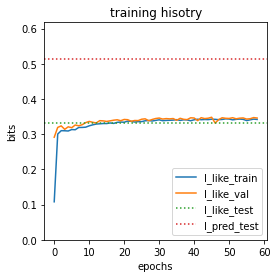

In [6]:
# Show training history
print('On test data:')
x_test = test_df['x'].values
y_test = test_df[y_cols].values

# Compute likelihood information
I_like, dI_like =  model.I_likelihood(x=x_test, y=y_test)
print(f'I_like_test: {I_like:.3f} +- {dI_like:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

I_like_hist = model.history['I_like']
val_I_like_hist = model.history['val_I_like']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_like_hist, label='I_like_train')
ax.plot(val_I_like_hist, label='I_like_val')
ax.axhline(I_like, color='C2', linestyle=':', label='I_like_test')
ax.axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
ax.set_ylim([0, I_pred*1.2]);

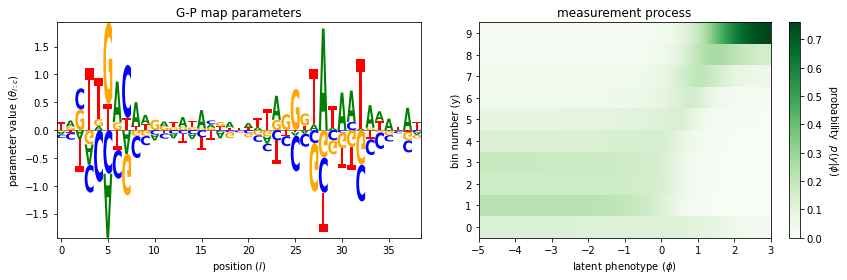

In [7]:
# Get G-P map parameters in matrix form
theta = model.get_theta(gauge='uniform')

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = model.model.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
measurement_process = model.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,2,figsize=[12,4])

# Left panel: draw logo using logomaker
ax = axs[0]
logo = logomaker.Logo(theta['logomaker_df'], ax=ax)
ax.set_ylabel(r'parameter value ($\theta_{l:c}$)')
ax.set_xlabel(r'position ($l$)')
ax.set_title('G-P map parameters')

# Right panel: draw measurement process as heatmap
ax = axs[1]
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process')
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout(w_pad=3)
fig.savefig('sortseq_mpa_visualization.png')
plt.show()

In [8]:
# Test simulate_data
sim_df = model.simulate_dataset(N=len(data_df))
sim_df.head()

,set,phi,ct_0,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,ct_8,ct_9,x
0,training,0.033561,0,0,0,0,0,1,0,0,0,0,GGCTTTACACTATATGCTTCCGGCTCGTATGTAGTGTGG
1,training,-1.518641,1,0,0,0,0,0,0,0,0,0,GGCTGTTGACTTTATGCCTCCGGCTCGTATGTTGTGTGG
2,training,-0.534395,0,0,0,0,1,0,0,0,0,0,GGCATTGCACTCTATGCTTACGGCTCGTATGTTGTGTTG
3,validation,0.655894,0,0,0,0,0,0,1,0,0,0,GTCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG
4,training,1.440613,1,0,0,0,0,0,0,0,0,0,GCCTTGACACTTTGTACTTCCGGCTCGTATGGTGTGTGG


In [9]:
# Separate test from data_df
ix_test = (sim_df['set']=='test')
sim_test_df = sim_df[ix_test].reset_index(drop=True)
print(f'test N: {len(sim_test_df):,}')

# Remove test data from data_df
sim_df = sim_df[~ix_test].reset_index(drop=True)
print(f'training + validation N: {len(sim_df):,}')
sim_df.head(10)

test N: 7,338
training + validation N: 29,111


,set,phi,ct_0,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,ct_8,ct_9,x
0,training,0.033561,0,0,0,0,0,1,0,0,0,0,GGCTTTACACTATATGCTTCCGGCTCGTATGTAGTGTGG
1,training,-1.518641,1,0,0,0,0,0,0,0,0,0,GGCTGTTGACTTTATGCCTCCGGCTCGTATGTTGTGTGG
2,training,-0.534395,0,0,0,0,1,0,0,0,0,0,GGCATTGCACTCTATGCTTACGGCTCGTATGTTGTGTTG
3,validation,0.655894,0,0,0,0,0,0,1,0,0,0,GTCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG
4,training,1.440613,1,0,0,0,0,0,0,0,0,0,GCCTTGACACTTTGTACTTCCGGCTCGTATGGTGTGTGG
5,training,-0.506816,0,0,0,0,1,0,0,0,0,0,GGCTTTATACTTTATGCTTCCGGGTAGTCTGGTGTGTGT
6,training,0.411897,0,0,0,0,0,1,0,0,0,0,GGCGTTACACATTATGACTCCAGGTAGTATGTTGTGTGG
7,training,-1.003345,0,0,1,0,0,0,0,0,0,0,GGCTTTACACTTTAAGCTTCCCGCTCGTCTGTTGTGTGG
8,training,-0.984117,0,0,1,0,0,0,0,0,0,0,CGCGTCACATTTTATGGCTCCGGCTCTTATGTTGTTTCG
9,training,-0.610567,0,0,0,0,1,0,0,0,0,0,GGCTTTAAGCTTTACGCTTACGGCTCGTATGTTGTGTGG


In [10]:
# Define model
sim_model = mavenn.Model(regression_type='MPA',
                       L=L,
                       Y=Y,
                       alphabet='dna',
                       gpmap_type='additive',
                       mpa_hidden_nodes=100)

# Where is ct_n?
sim_model.set_data(x=sim_df['x'],
                   y=sim_df[y_cols])

# Fit model to data
sim_model.fit(learning_rate=.005,
              epochs=1000,
              batch_size=500,
              early_stopping=True,
              early_stopping_patience=10,
              linear_initialization=True)

N = 29,111 observations set as training data.
Using 20.4% for validation.
Data shuffled.
Time to set data: 0.33 sec.
 
LSMR            Least-squares solution of  Ax = b

The matrix A has    23179 rows  and      156 cols
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =      156

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  7.886e+02  5.538e+05   1.0e+00  8.9e-01
     1  5.57778e-03  4.319e+02  1.017e+04   5.5e-01  2.8e-02  8.4e+02  1.0e+00
     2 -1.29507e-02  3.931e+02  2.697e+03   5.0e-01  8.2e-03  8.4e+02  1.5e+01
     3 -1.12226e-01  3.874e+02  1.415e+03   4.9e-01  4.3e-03  8.4e+02  2.1e+01
     4 -2.00135e-01  3.852e+02  5.520e+02   4.9e-01  1.7e-03  8.4e+02  2.2e+01
     5 -2.12733e-01  3.850e+02  3.022e+02   4.9e-01  9.3e-04  8.5e+02  2.0e+01
     6 -2.14189e-01  3.850e+02  2.577e+02   4.9e-01  6.8e-04  9.8e+02  2.0e+01
     7 -2.09190e-01  3.849e+02  1.01

Epoch 46/1000
47/47 [==============================] - 0s 6ms/step - loss: 1046.2728 - I_like: 0.2995 - val_loss: 1045.5015 - val_I_like: 0.2869
Epoch 47/1000
47/47 [==============================] - 0s 7ms/step - loss: 1045.9962 - I_like: 0.3013 - val_loss: 1045.8710 - val_I_like: 0.2855
Epoch 48/1000
47/47 [==============================] - 0s 6ms/step - loss: 1046.2610 - I_like: 0.2985 - val_loss: 1045.6798 - val_I_like: 0.2860
Epoch 49/1000
47/47 [==============================] - 0s 6ms/step - loss: 1045.7308 - I_like: 0.3002 - val_loss: 1045.6704 - val_I_like: 0.2862
Epoch 50/1000
47/47 [==============================] - 0s 6ms/step - loss: 1045.4883 - I_like: 0.3004 - val_loss: 1046.6095 - val_I_like: 0.2834
Epoch 51/1000
47/47 [==============================] - 0s 6ms/step - loss: 1047.1793 - I_like: 0.2943 - val_loss: 1047.4702 - val_I_like: 0.2808
Epoch 52/1000
47/47 [==============================] - 0s 6ms/step - loss: 1045.8610 - I_like: 0.3021 - val_loss: 1046.0338 - val_

On test data:
I_intr_like: 0.302 +- 0.009 bits
I_intr_pred: 0.305 +- 0.014 bits
I_like_test: 0.286 +- 0.009 bits
I_pred_test: 0.316 +- 0.012 bits


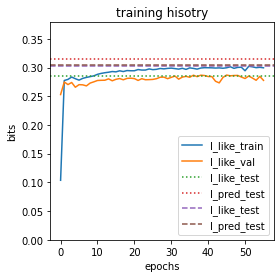

In [11]:
# Show training history
print('On test data:')
x_test = sim_test_df['x'].values
y_test = sim_test_df[y_cols].values

# Compute the intrinsic information using the true model
I_intr_like, dI_intr_like =  model.I_likelihood(x=x_test, y=y_test)
print(f'I_intr_like: {I_intr_like:.3f} +- {dI_intr_like:.3f} bits') 

I_intr_pred, dI_intr_pred =  model.I_predictive(x=x_test, y=y_test)
print(f'I_intr_pred: {I_intr_pred:.3f} +- {dI_intr_pred:.3f} bits') 

# Compute likelihood information
I_like, dI_like =  sim_model.I_likelihood(x=x_test, y=y_test)
print(f'I_like_test: {I_like:.3f} +- {dI_like:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = sim_model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

I_like_hist = sim_model.history['I_like']
val_I_like_hist = sim_model.history['val_I_like']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_like_hist, label='I_like_train')
ax.plot(val_I_like_hist, label='I_like_val')
ax.axhline(I_like, color='C2', linestyle=':', label='I_like_test')
ax.axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax.axhline(I_intr_like, color='C4', linestyle='--', label='I_like_test')
ax.axhline(I_intr_pred, color='C5', linestyle='--', label='I_pred_test')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
ax.set_ylim([0, I_pred*1.2]);